Row
    [0] Column
        [0] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
        [1] Row
            [0] Column
                [0] Row
                    [0] Matplotlib(Figure)
                [1] Row
                    [0] PNG(str, width=920)
    [1] Column
        [0] Column
            [0] Markdown(str)
            [1] RangeSlider(end=100, name='ECA [mS/m]', start=1, step=4.95, value=(1, 100))
            [2] RangeSlider(end=1.5, name='ThickA [m]', start=0.05, step=0.0725, value=(0.05, 1.5))
            [3] RangeSlider(end=100, name='ECB [mS/m]', start=1, step=4.95, value=(1, 100))
            [4] RangeSlider(end=2.0, name='ThickB [m]', start=0.1, step=0.095, value=(0.05, 2.0))
            [5] RangeSlider(end=100, name='ECC [mS/m]', start=1, step=4.95, value=(1, 100))
            [6] FloatSlider(end=12, name='Unique parameter values', start=6, step=1, value=6)
            [7] Markdown(str)
            [8] Row
                [0] Checkbox(max_width=110, name='HCP', value=True)
                [1] Checkbox(max_width=110, name='VCP', value=True)
                [2] Checkbox(max_width=30, name='PRP', value=True)
            [9] Markdown(str)
            [10] Row
                [0] Checkbox(max_width=110, name='1.0m', value=True)
                [1] Checkbox(max_width=110, name='2.5m', value=True)
                [2] Checkbox(max_width=30, name='4.0m', value=True)
            [11] Markdown(str)
            [12] Row
                [0] Checkbox(max_width=110, name='0.1m', value=True)
                [1] Checkbox(max_width=110, name='0.3m', value=True)
                [2] Checkbox(max_width=30, name='0.5m', value=True)
        [1] Column
            [0] TextInput(name='Run time EMagPy [min]', value='0.2')
            [1] TextInput(name='Run time ML [min]', value='4')
        [2] Button(name='Run ML')
        [3] Button(name='Run EMagPy')
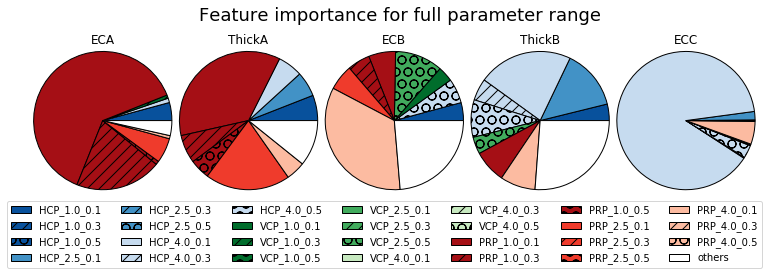
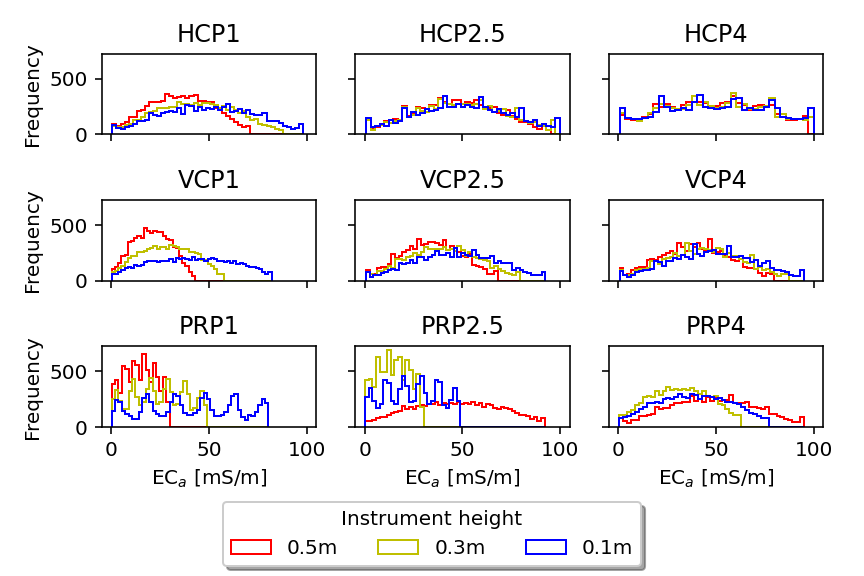
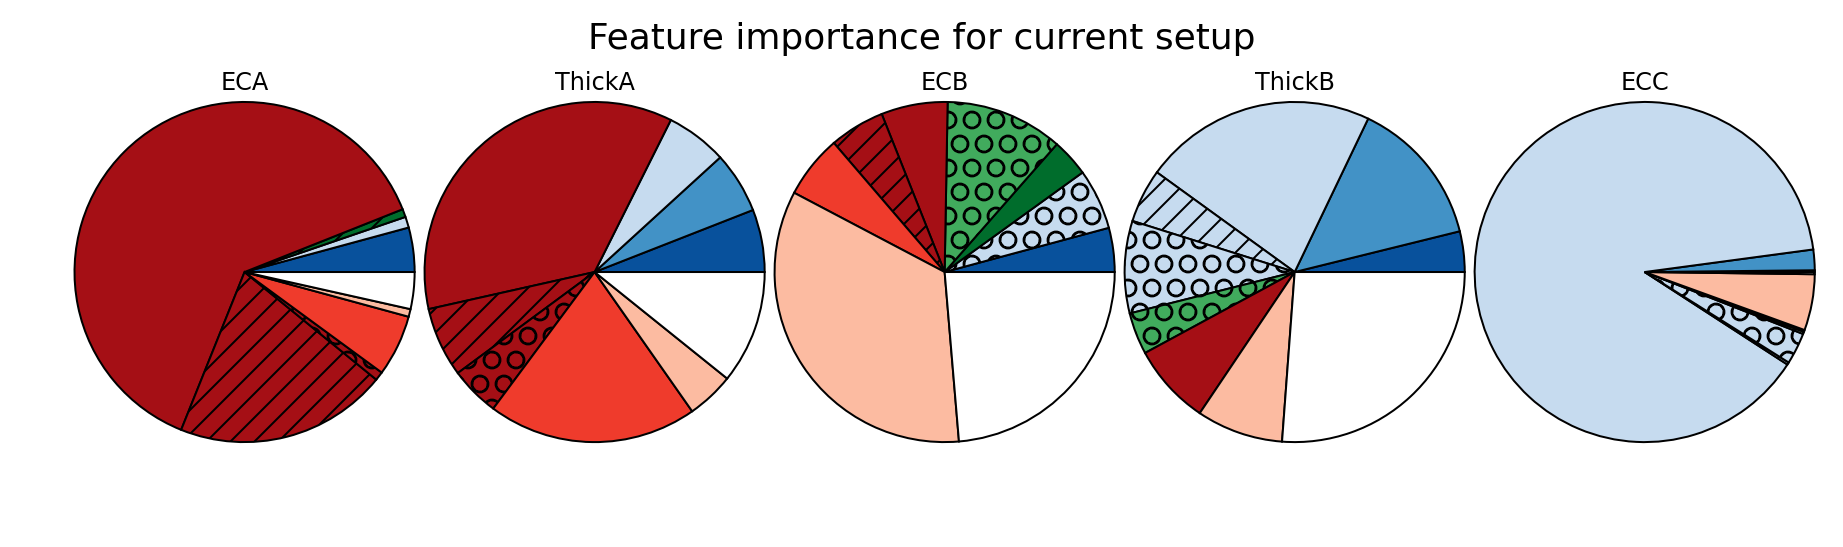
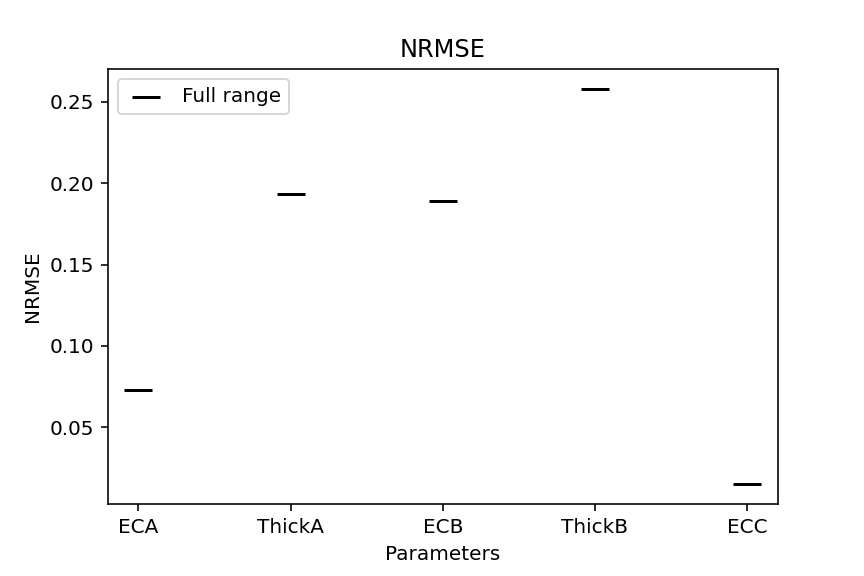

In [1]:
################################################################################################
#                                      Libs
################################################################################################
#Import best libraries ever made
import pandas as pd
import numpy as np

#Panel
import param
import panel as pn
pn.extension()
import panel.widgets as pnw

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Machine learning
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
import random
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats

#EMI
from emagpy import invertHelper as ih

#warnings - To do: correct warnings instead of suppressinng
import warnings
warnings.filterwarnings("ignore")

################################################################################################
#                                      run ml
################################################################################################
def ml(dataframe,obstype):    
    numrepeats=5                                                                   # number of times to repeat training to test stabilty of results
    regressionmodel=1                                                              # 0=regression tree, 1=gradient boosting, 2=random forest
    min_max_scaler = preprocessing.MinMaxScaler()
    max_depth=10                                                                   # maximum number of levels of tree
    min_samples_leaf=2                                                             # splits per node
    importancethreshold=0  

    data3 = dataframe[:,5:]                                                           

    rmse_all_train_wrpt = np.zeros((numrepeats,5))
    rmse_all_test_wrpt = np.zeros((numrepeats,5))
    R2_all_train_wrpt = np.zeros((numrepeats,5))
    R2_all_test_wrpt = np.zeros((numrepeats,5))
    importance_all_wrpt = np.zeros((numrepeats,5,np.shape(obstype)[0]))

    for rpt in np.arange(numrepeats):
        #print()
        #print('repeat ',rpt)
        for trgt in np.arange(5):
            trgt_list = [int(trgt)]
            #print('target ',trgt)

            data2 = dataframe[:,:5]                                                         # EC_A, Thick_A, EC_B, Thick_B and EC_C
            target=data2[:,trgt_list]                                                       # define specific target to predict and data to consider

            if np.ndim(target)==1:                                                          # do some gymnastics to concatentate features and targets allowing for only a single target
                addcols=1
            else:
                addcols=np.shape(target)[1]
            data=np.zeros((np.shape(data3)[0],np.shape(data3)[1]+addcols))
            data[:,:-addcols]=data3
            data[:,-addcols:]=target

            Predictions_use=data[:,np.shape(data)[1]-addcols:]                                                   # normalize target for ML analysis and save values to recover unnormalized values later
            Predictions_usemean=np.mean(Predictions_use,axis=0)
            Predictions_userange=np.max(Predictions_use,axis=0)-np.min(Predictions_use,axis=0)
            Predictions_usemin=np.min(Predictions_use,axis=0)
            Predictions_usestd=np.std(Predictions_use,axis=0)    
            Predictions_use_norm = min_max_scaler.fit_transform(Predictions_use)           # normalizing flux DOES appear to be necessary, have to remember to un-normalize for later plots


            #data2frame=np.hstack((data[:,:-1],Predictions_use_norm))                      # replace targets with normalized targets
            data2frame = data.copy()
            data2frame[:,np.shape(data)[1]-addcols:] = Predictions_use_norm


            fract_train=0.7                                                                # define fraction of data to use for training
            numtrain=int(fract_train*np.shape(data)[0])                                    # find number of training points
            train_t=np.sort(random.sample(range(np.shape(data)[0]), numtrain))             # find times of training points
            test_t=np.arange(np.shape(data)[0])                                            # find times of testing points
            test_t = [i for i in test_t if i not in train_t]

            training_data=data2frame[train_t,:]                                            # extract training data 
            testing_data=data2frame[test_t,:]                                              # extract testing data 

            if regressionmodel==0:                                                         # run machine learning analysis
                regression_model = DecisionTreeRegressor(criterion="mse",max_depth=max_depth, min_samples_leaf=min_samples_leaf)                      # MSE == varince is spliting criteria, minimum instances per leaf = 5
                regression_model.fit(training_data[:,:-addcols],training_data[:,np.shape(data)[1]-addcols:])
            elif regressionmodel==1:    
                regression_model = ensemble.GradientBoostingRegressor(criterion="mse",max_depth=max_depth, min_samples_leaf=min_samples_leaf)                      # MSE == varince is spliting criteria, minimum instances per leaf = 5
                regression_model.fit(training_data[:,:-addcols],training_data[:,np.shape(data)[1]-addcols:])
            else:    
                regression_model = ensemble.RandomForestRegressor(criterion="mse",max_depth=max_depth, min_samples_leaf=min_samples_leaf)                      # MSE == varince is spliting criteria, minimum instances per leaf = 5
                regression_model.fit(training_data[:,:-addcols],training_data[:,np.shape(data)[1]-addcols:])

            predicted_train = regression_model.predict(training_data[:,:-addcols])          # calculate predictions for training
            predicted_train = predicted_train*Predictions_userange[0]+Predictions_usemin[0] # un-normalize predictions for training
            true_train=Predictions_use[train_t]                                             # store correct target values for training
            predicted = regression_model.predict(testing_data[:,:-addcols])                 # calculate predictions for testing
            predicted = predicted*Predictions_userange[0]+Predictions_usemin[0]             # un-normalize predictions for testing
            true=Predictions_use[test_t]                                                    # store correct target values for testing

            importance = regression_model.feature_importances_                              # find feature importance values

            slope, intercept, r_value_train, p_value, std_err = scipy.stats.linregress(np.squeeze(true_train), predicted_train)    
            R2_train=r_value_train**2
            rmse_train = sqrt(mean_squared_error(np.squeeze(true_train), predicted_train))

            slope, intercept, r_value_test, p_value, std_err = scipy.stats.linregress(np.squeeze(true), predicted)    
            R2_test=r_value_test**2
            rmse_test = sqrt(mean_squared_error(np.squeeze(true), predicted))

            rmse_all_train_wrpt[rpt,trgt]=rmse_train 
            rmse_all_test_wrpt[rpt,trgt]=rmse_test
            R2_all_train_wrpt[rpt,trgt]=R2_train
            R2_all_test_wrpt[rpt,trgt]=R2_test
            importance_all_wrpt[rpt,trgt,:]=importance

    mean_rmse_all_train  =np.mean(rmse_all_train_wrpt,axis=0)
    mean_rmse_all_test   =np.mean(rmse_all_test_wrpt,axis=0)    
    mean_R2_all_train    =np.mean(R2_all_train_wrpt,axis=0)
    mean_R2_all_test     =np.mean(R2_all_test_wrpt,axis=0)
    mean_importance_all  =np.mean(importance_all_wrpt,axis=0)
    var_importance_all   =np.var(importance_all_wrpt,axis=0)
    
    mrat = [mean_rmse_all_test[0]/99,
            mean_rmse_all_test[1]/1.45,
            mean_rmse_all_test[2]/99,
            mean_rmse_all_test[3]/1.9,
            mean_rmse_all_test[4]/99]
    
    #col = ['HCP_1.0_0.1', 'HCP_1.0_0.3', 'HCP_1.0_0.5','HCP_2.5_0.1', 'HCP_2.5_0.3', 'HCP_2.5_0.5','HCP_4.0_0.1', 'HCP_4.0_0.3', 'HCP_4.0_0.5',           
    #       'VCP_1.0_0.1', 'VCP_1.0_0.3', 'VCP_1.0_0.5','VCP_2.5_0.1', 'VCP_2.5_0.3', 'VCP_2.5_0.5','VCP_4.0_0.1', 'VCP_4.0_0.3', 'VCP_4.0_0.5',       
    #       'PRP_1.0_0.1', 'PRP_1.0_0.3', 'PRP_1.0_0.5','PRP_2.5_0.1', 'PRP_2.5_0.3', 'PRP_2.5_0.5','PRP_4.0_0.1', 'PRP_4.0_0.3', 'PRP_4.0_0.5']

    mia = pd.DataFrame(mean_importance_all,columns = obstype)
    #print('ml done')
    return mrat,mia

################################################################################################
#                                   Emi hist 
################################################################################################

def emi_hist(emi_data):   
    #Titles, column numbers and colours
    titles = [['HCP1', 'HCP2.5', 'HCP4'], ['VCP1', 'VCP2.5', 'VCP4'],['PRP1', 'PRP2.5', 'PRP4']]
    num = [[5,8,11],[14,17,20],[23,24,27]]
    colour = ["b","y","r"]
    
    #Plot
    fig, axes = plt.subplots(nrows = 3, ncols = 3,  sharex=True, sharey=True)
    for i, row in enumerate(axes):
        for j, cell in enumerate(row):
                    if num[i][j] == 5:
                        legend = ["0.1m","0.3m","0.5m"]
                    else:
                        legend='_nolegend_'
                    cell.hist([emi_data[emi_data.columns[num[i][j]]],emi_data[emi_data.columns[num[i][j]+1]],emi_data[emi_data.columns[num[i][j]+2]]]
                              ,bins='auto', alpha=1, rwidth=0.85, label=legend, color=colour, histtype='step')
                    cell.set_title(titles[i][j])
                    if i == len(axes) - 1:
                        cell.set_xlabel("EC$_a$ [mS/m]".format(j + 1))
                    if j == 0:
                        cell.set_ylabel("Frequency".format(i + 1))

    fig.legend(loc='lower center', bbox_to_anchor=(0.5, 0.0),fancybox=True, shadow=True, ncol=3,title = "Instrument height")
    plt.tight_layout(rect=[0,0.1,0.99,1])
    plt.close(fig)
    return fig

################################################################################################
#                                   feature importance 
################################################################################################

def full_feat_imp():
    full = pd.read_csv('Mean_imp_ThickA_full.csv', index_col=0,sep=',')
    col = ['HCP_1.0_0.1', 'HCP_1.0_0.3', 'HCP_1.0_0.5',
           'HCP_2.5_0.1', 'HCP_2.5_0.3', 'HCP_2.5_0.5',
           'HCP_4.0_0.1', 'HCP_4.0_0.3', 'HCP_4.0_0.5',

           'VCP_1.0_0.1', 'VCP_1.0_0.3', 'VCP_1.0_0.5',
           'VCP_2.5_0.1', 'VCP_2.5_0.3', 'VCP_2.5_0.5',
           'VCP_4.0_0.1', 'VCP_4.0_0.3', 'VCP_4.0_0.5',

           'PRP_1.0_0.1', 'PRP_1.0_0.3', 'PRP_1.0_0.5',
           'PRP_2.5_0.1', 'PRP_2.5_0.3', 'PRP_2.5_0.5',
           'PRP_4.0_0.1', 'PRP_4.0_0.3', 'PRP_4.0_0.5']

    df = pd.DataFrame(columns=col)
    cfg = df.columns

    param = [0,1,2,3,4]
    par_name = ['ECA', 'ThickA', 'ECB', 'ThickB', 'ECC']
    idx = ['full','cen','sl','sh']

    fig = plt.figure(figsize=(12.8,3.8))
    size=7
    spec = gridspec.GridSpec(ncols=5, nrows=1, wspace = 11.35)
    axs = []

    for ipar in param:
        par = ipar #0=ECA, 1=ThickA, 2=ECB, 3=ThickB, 4=ECC

        f =  full.iloc[par,:].values    
        ECA_imp = pd.DataFrame([f],columns = cfg, index = idx) #only use the full range (f) for this plot
        mean = ECA_imp.mean() #Mean of each column

        p_val = 8      #Values to plot seperately
        o_val = 27-p_val #Values to aggregate into "others" white category
        # sum of p_val & o_val must be 27

        if p_val + o_val != 27:
            print("Values are not equal 27")
            exit(0)

        most_imp = np.argsort(-np.asarray(mean))[:p_val] # The # most important feats
        other = cfg[np.argsort(-np.asarray(mean))[-o_val:]] #Other bin

        #Re-sort the most imp feats based on the order they appear originally so the coil pos are next to each other 
        most_imp_sort = np.sort(most_imp) 

        #Full
        f_other_val = f[np.argsort(-np.asarray(mean))[-o_val:]].sum()
        full_val = f[most_imp_sort]
        full_val= np.append(full_val,f_other_val)

        #Labels
        label = list(cfg[most_imp_sort])
        label.append('others')

        ##################################################################################
        #                       Custom colourmap                    
        ##################################################################################
        blue = cm.get_cmap('Blues',9)
        red = cm.get_cmap('Reds',9)
        green = cm.get_cmap('Greens',9)

        low, mid, high = 7,5,2
        white = (1.0, 1.0, 1.0, 1.0)
        hatches = [ "" , "//" , "O" , "" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O","" , "//" , "O","" ]
        clr = [blue(low),blue(low),blue(low),blue(mid),blue(mid),blue(mid),blue(high),blue(high),blue(high),
               green(low),green(low),green(low),green(mid),green(mid),green(mid),green(high),green(high),green(high),
               red(low),red(low),red(low),red(mid),red(mid),red(mid),red(high),red(high),red(high),
               white]

        newcolor =  []
        for i in most_imp_sort:
            newcolor.append(clr[i])
        newcolor.append(white) #Other category is always white

        newhatches = []
        for j in most_imp_sort:
            newhatches.append(hatches[j])
        newhatches.append("")

        cmap = ListedColormap(newcolor,N=p_val)  
        
        ############################# With hatches ######################################
        #fig1, f1_axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True)

        #vals = [sh_val,sl_val,c_val,full_val]
        vals = [full_val]
        size = size
        #radius = [1+size*2,1+size,1,1-size]
        radius = [1+size*2]

        axs.append(fig.add_subplot(spec[0, ipar]))

        for ival,ir in zip(vals,radius):
            piechart = axs[-1].pie(ival, radius = ir, wedgeprops=dict(edgecolor='k'), colors=newcolor)
            for i in range(len(piechart[0])):
                piechart[0][i].set_hatch(newhatches[(i)%len(newhatches)])

        #axs[-1].text(-0.1,0.0,par_name[ipar])
        #ax.legend(loc='upper left', labels=label,prop={'size': 12}, bbox_to_anchor=(-0.1, 1), bbox_transform=fig.transFigure)
        axs[-1].set_title(par_name[ipar],y=6.5)
        #plt.show()

    #axs.append(fig.add_subplot(spec[0, 5]))
    patches = []
    conf = list(cfg)
    conf.append('others')
    for ic,icfg,ih in zip(clr,conf,hatches):
        patches.append(mpatches.Patch(facecolor=ic, hatch=ih, label=icfg, edgecolor='k'))

    #plt.legend(handles=patches,ncol=7, bbox_to_anchor=(1.25, -0.2))#,prop={'size': 12}, bbox_transform = fig.transFigure)    
    fig.suptitle('Feature importance for current setup', fontsize = 18, x = 0.5, y = 0.96)
    #plt.tight_layout(rect=[0,0.1,0.99,0.1])
    plt.close()  
    return fig

################################################################################################
#                                 update feature importance 
################################################################################################
def upd_feat_imp(df):
    full = df #pd.read_csv('Mean_imp_ThickA_full.csv', index_col=0,sep=',')
    
    col = ['hcp_1.0_0.1', 'hcp_1.0_0.3', 'hcp_1.0_0.5',
           'hcp_2.5_0.1', 'hcp_2.5_0.3', 'hcp_2.5_0.5',
           'hcp_4.0_0.1', 'hcp_4.0_0.3', 'hcp_4.0_0.5',

           'vcp_1.0_0.1', 'vcp_1.0_0.3', 'vcp_1.0_0.5',
           'vcp_2.5_0.1', 'vcp_2.5_0.3', 'vcp_2.5_0.5',
           'vcp_4.0_0.1', 'vcp_4.0_0.3', 'vcp_4.0_0.5',

           'prp_1.0_0.1', 'prp_1.0_0.3', 'prp_1.0_0.5',
           'prp_2.5_0.1', 'prp_2.5_0.3', 'prp_2.5_0.5',
           'prp_4.0_0.1', 'prp_4.0_0.3', 'prp_4.0_0.5']

    temp_df = pd.DataFrame(columns=col)
    cfg = temp_df.columns

    num = [col.index(x) for x in list(full.columns.values)]
    #num
    #cfg = full.columns

    param = [0,1,2,3,4]
    par_name = ['ECA', 'ThickA', 'ECB', 'ThickB', 'ECC']
    idx = ['full','cen','sl','sh']

    fig = plt.figure(figsize=(12.8,3.8))
    size=7
    spec = gridspec.GridSpec(ncols=5, nrows=1, wspace = 11.35)
    axs = []

    for ipar in param:
        par = ipar #0=ECA, 1=ThickA, 2=ECB, 3=ThickB, 4=ECC

        f =  full.iloc[par,:].values    
        ECA_imp = pd.DataFrame([f],columns = cfg[num], index = idx) #only use the full range (f) for this plot
        mean = ECA_imp.mean() #Mean of each column

        p_val = 8      #Values to plot seperately
        o_val = len(cfg)-p_val #Values to aggregate into "others" white category
        # sum of p_val & o_val must be 27

        if p_val + o_val != len(cfg):
            print("Values are not equal column names")
            exit(0)

        most_imp = np.argsort(-np.asarray(mean))[:p_val] # The # most important feats
        other = cfg[np.argsort(-np.asarray(mean))[-o_val:]] #Other bin

        #Re-sort the most imp feats based on the order they appear originally so the coil pos are next to each other 
        most_imp_sort = np.sort(most_imp) 

        #Full
        f_other_val = f[np.argsort(-np.asarray(mean))[-o_val:]].sum()
        full_val = f[most_imp_sort]
        full_val= np.append(full_val,f_other_val)

        #Labels
        label = list(cfg[most_imp_sort])
        label.append('others')

        ##################################################################################
        #                       Custom colourmap                    
        ##################################################################################
        blue = cm.get_cmap('Blues',9)
        red = cm.get_cmap('Reds',9)
        green = cm.get_cmap('Greens',9)

        low, mid, high = 7,5,2
        white = (1.0, 1.0, 1.0, 1.0)
        hatches_all = [ "" , "//" , "O" , "" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O" ,"" , "//" , "O","" , "//" , "O","" ]
        clr_all = [blue(low),blue(low),blue(low),blue(mid),blue(mid),blue(mid),blue(high),blue(high),blue(high),
               green(low),green(low),green(low),green(mid),green(mid),green(mid),green(high),green(high),green(high),
               red(low),red(low),red(low),red(mid),red(mid),red(mid),red(high),red(high),red(high),
               white]

        hatches = np.array(hatches_all)[num]
        clr = np.array(clr_all)[num]

        newcolor =  []
        for i in most_imp_sort:
            newcolor.append(clr[i])
        newcolor.append(white) #Other category is always white

        newhatches = []
        for j in most_imp_sort:
            newhatches.append(hatches[j])
        newhatches.append("")

        cmap = ListedColormap(newcolor,N=p_val)  

        ############################# With hatches ######################################
        #fig1, f1_axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True)

        #vals = [sh_val,sl_val,c_val,full_val]
        vals = [full_val]
        size = size
        #radius = [1+size*2,1+size,1,1-size]
        radius = [1+size*2]

        axs.append(fig.add_subplot(spec[0, ipar]))

        for ival,ir in zip(vals,radius):
            piechart = axs[-1].pie(ival, radius = ir, wedgeprops=dict(edgecolor='k'), colors=newcolor)
            for i in range(len(piechart[0])):
                piechart[0][i].set_hatch(newhatches[(i)%len(newhatches)])

        #axs[-1].text(-0.1,0.0,par_name[ipar])
        #ax.legend(loc='upper left', labels=label,prop={'size': 12}, bbox_to_anchor=(-0.1, 1), bbox_transform=fig.transFigure)
        axs[-1].set_title(par_name[ipar],y=6.5)
        #plt.show()

    #axs.append(fig.add_subplot(spec[0, 5]))
    patches = []
    conf = list(cfg[num])
    conf.append('others')
    for ic,icfg,ih in zip(clr,conf,hatches):
        patches.append(mpatches.Patch(facecolor=ic, hatch=ih, label=icfg, edgecolor='k'))

    #plt.legend(handles=patches,ncol=7, bbox_to_anchor=(1.25, -0.2))#,prop={'size': 12}, bbox_transform = fig.transFigure)    
    fig.suptitle('Feature importance for current setup', fontsize = 22, x = 0.5, y = 0.96)
    #plt.tight_layout(rect=[0,0.1,0.99,0.1])
    #plt.close()
    return fig

###############################################################################
#                              EMI hist
###############################################################################
def create_emimatrix(eca,thicka,ecb,thickb,ecc,numparam):
    numparamsteps=numparam.value

    ECA_min = eca.value[0]
    ECA_max = eca.value[1]   
    ECB_min = ecb.value[0]
    ECB_max = ecb.value[1]   
    ECC_min = ecc.value[0]
    ECC_max = ecc.value[1]    
    thickA_min = thicka.value[0]
    thickA_max = thicka.value[1]      
    thickB_min = thickb.value[0]
    thickB_max = thickb.value[1]
     
    #ECA_step=(ECA_max-ECA_min)/(numparamsteps-1)
    #ECA=np.arange(ECA_min,ECA_max+ECA_step,ECA_step)
    #ECB_step=(ECB_max-ECB_min)/(numparamsteps-1)
    #ECB=np.arange(ECB_min,ECB_max+ECB_step,ECB_step)
    #ECC_step=(ECC_max-ECC_min)/(numparamsteps-1)
    #ECC=np.arange(ECC_min,ECC_max+ECC_step,ECC_step)

    #thickA_step=(thickA_max-thickA_min)/(numparamsteps-1)
    #thickA=np.arange(thickA_min,thickA_max+thickA_step,thickA_step)
    #thickA=np.linspace(thickA_min,thickA_max,numparamsteps)

    #thickB_step=(thickB_max-thickB_min)/(numparamsteps-1)
    #thickB=np.arange(thickB_min,thickB_max+thickB_step,thickB_step)

    ECA = np.linspace(ECA_min,ECA_max,numparamsteps)
    ECA_step = ECA[1] - ECA[0]
    ECB = np.linspace(ECB_min,ECB_max,numparamsteps)
    ECB_step = ECB[1] - ECB[0]
    ECC = np.linspace(ECC_min,ECC_max,numparamsteps)
    ECC_step = ECC[1] - ECC[0]

    thickA = np.linspace(thickA_min,thickA_max,numparamsteps)
    thickA_step = thickA[1] - thickA[0]
    thickB = np.linspace(thickB_min,thickB_max,numparamsteps)
    thickB_step = thickB[1] - thickB[0]


    ###############################################################################
    # Allow user to choose which EMI setups to include in design 
    # Allow user to define range of instrument heights
    # Instrument heights vary linearly between limits with num_inst_heights values
    ###############################################################################
    num_inst_height=3
    inst_height_max=0.5
    inst_height_min=0.1

    inst_height_step=(inst_height_max-inst_height_min)/(num_inst_height-1)
    inst_height=np.arange(inst_height_min,inst_height_max+inst_height_step,inst_height_step)

    num_ant_sep=3
    ant_sep_max=4
    ant_sep_min=1

    ant_sep_step=(ant_sep_max-ant_sep_min)/(num_ant_sep-1)
    ant_sep=np.arange(ant_sep_min,ant_sep_max+ant_sep_step,ant_sep_step)

    # 1=consider, 0=exclude
    hcp=1                                                                          
    vcp=1
    prp=1
    ant_orients=['hcp','vcp','prp']
    if prp==0:
        ant_orients.remove('prp')
    if vcp==0:
        ant_orients.remove('vcp')
    if hcp==0:
        ant_orients.remove('hcp')
        
    #inst_height=[0.1, 0.3, 0.5]   
    #if ten.value == False:
    #    inst_height.remove(0.1)
    #if thirty.value == False:
    #    inst_height.remove(0.3)
    #if fifty.value == False:
    #    inst_height.remove(0.5)
    
    #ant_sep=[1.0, 2.5, 4.0]   
    #if one.value == False:
    #    ant_sep.remove(1.0)
    #if two.value == False:
    #    ant_sep.remove(2.5)
    #if four.value == False:
    #    ant_sep.remove(4.0)
    
    #ant_orients=['hcp','vcp','prp']   
    #if prp.value == False:
    #    ant_orients.remove('prp')
    #if vcp.value == False:
    #    ant_orients.remove('vcp')
    #if hcp.value == False:
    #    ant_orients.remove('hcp')

    ###############################################################################
    # Calculate EMI response for every instrument configuration and parameter combination
    ###############################################################################
    arraysize1 = np.shape(ECA)[0]*np.shape(thickA)[0]*np.shape(ECB)[0]*np.shape(thickB)[0]*np.shape(ECC)[0]
    arraysize2 = np.shape(inst_height)[0]*np.shape(ant_sep)[0]*np.shape(ant_orients)[0]
    EMImatrix = np.empty((arraysize1, arraysize2+5))
    obstype=[]
    count0=-1
    count3=-1
    IDmatrix=np.zeros((np.shape(ant_orients)[0], np.shape(ant_sep)[0],np.shape(inst_height)[0]))
    for orientation in ant_orients:
        count0+=1
        count1=-1
        for sep in ant_sep:
            count1+=1
            count2=-1        
            for height in inst_height:
                count2+=1
                count3+=1
                tempname=orientation+'_'+str(np.round(sep,3))+'_'+str(np.round(height,3))
                obstype.append(tempname)
                IDmatrix[count0,count1,count2]=count3

    counter2=-1
    count=0
    for EC3 in ECC:
        for th2 in thickB:
            for EC2 in ECB:
                for th1 in thickA:   
                    for EC1 in ECA:
                        counter2+=1
                        counter1=-1
                        for orientation in ant_orients:
                            for sep in ant_sep:
                                sep_list = [float(sep)]
                                for height in inst_height:
                                    orientation_list = [str(orientation)]
                                    counter1+=1  

                                    cond = [EC1, EC2, EC3]
                                    depths = [th1, th1+th2]                                   
                                    count+=1
                                    EMI = ih.fCS(np.array(cond), depths, s=sep_list, cpos=orientation_list, hx=height)

                                    EMImatrix[counter2,0] = EC1                    # [mS/m]
                                    EMImatrix[counter2,1] = th1                    # [m]
                                    EMImatrix[counter2,2] = EC2                    # [mS/m]
                                    EMImatrix[counter2,3] = th2                    # [m]
                                    EMImatrix[counter2,4] = EC3                    # [mS/m]
                                    EMImatrix[counter2,5+counter1] = EMI           # [mS/m] 
    #emi_array = EMImatrix    
    xtext = ['ECA', 'ThickA', 'ECB', 'ThickB', 'ECC']
    cols = xtext + obstype   
    emi_frame = pd.DataFrame(EMImatrix, columns = cols)
    return emi_frame

################################################################################################
#                                  Panel app
################################################################################################

######## Create widgets ########
#Button
button_ml  = pn.widgets.Button(name='Run ML')
button_emi = pn.widgets.Button(name='Run EMagPy')

#Image
png = pn.panel('Feat_imp_full.png', width=920)

#Sliders (instrument parameters)
eca     = pnw.RangeSlider(name='ECA [mS/m]', value=(1,100),    start=1,    end=100, step=4.95) 
thicka  = pnw.RangeSlider(name='ThickA [m]', value=(0.05,1.5), start=0.05, end=1.5, step=0.0725) 
ecb     = pnw.RangeSlider(name='ECB [mS/m]', value=(1,100),    start=1,    end=100, step=4.95) 
thickb  = pnw.RangeSlider(name='ThickB [m]', value=(0.05,2.0), start=0.1,  end=2.0, step=0.095) 
ecc     = pnw.RangeSlider(name='ECC [mS/m]', value=(1,100),    start=1,    end=100, step=4.95) 

#Number of unique parameter values
numparam =  pnw.FloatSlider(name='Unique parameter values', value=6, start=6, end=12, step=1) 

#Checkboxes (instrument parameters)
max_width  = 110
max_width2 = 30
hcp     = pn.widgets.Checkbox(name='HCP', max_width=max_width, value=True)
vcp     = pn.widgets.Checkbox(name='VCP', max_width=max_width, value=True)
prp     = pn.widgets.Checkbox(name='PRP', max_width=max_width2,value=True)

one     = pn.widgets.Checkbox(name='1.0m', max_width=max_width, value=True)
two     = pn.widgets.Checkbox(name='2.5m', max_width=max_width, value=True)
four    = pn.widgets.Checkbox(name='4.0m', max_width=max_width2,value=True)

ten     = pn.widgets.Checkbox(name='0.1m', max_width=max_width, value=True)
thirty  = pn.widgets.Checkbox(name='0.3m', max_width=max_width, value=True)
fifty   = pn.widgets.Checkbox(name='0.5m', max_width=max_width2,value=True)

#Text

#row_count   = pn.widgets.TextInput(name='Rows in EMI dataframe', value='100000')
run_timer_emi  = pnw.TextInput(name='Run time EMagPy [min]', value='0.2')
run_timer_ml   = pnw.TextInput(name='Run time ML [min]', value='4')
cpos        = "\n#### Coil position"
csep        = "\n#### Coil separation"
insh        = "\n#### Instrument height"
text_widget = pn.Column("<br>\n#### Parameters", eca, thicka, ecb, thickb, ecc, numparam,cpos,pn.Row(hcp,vcp,prp),csep,pn.Row(one,two,four),insh,pn.Row(ten,thirty,fifty))
timer_widget = pn.Column(run_timer_emi,run_timer_ml)

#Run time for EMagpy and ML in minutes displayed by the textbox
emi_time = [0.2, 0.4, 0.8, 1.5, 2.7, 4.3, 6.5] 
ml_time  = [4.0,  10,  22,  40,  69, 111, 173]

###### Create functions #######
#Callback for textboxes that show run times
#EMI
def callback1(target,event):
    target.value = str(emi_time[numparam.value-6])

#ML
def callback2(target,event):
    target.value = str(ml_time[numparam.value-6])    
    
#Recalculate EMI matrix with EMagpy    
def restrict_emi_variables():
    emi = create_emimatrix(eca,thicka,ecb,thickb,ecc,numparam)
    return emi_hist(emi)

#Run ML
def run_ml():    
    temp_data = create_emimatrix(eca,thicka,ecb,thickb,ecc,numparam)
    
    ################## Constrain it! ###############
    #Constrain based on coil position
    if hcp.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), 'hcp') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])

    if vcp.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), 'vcp') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])
   
    if prp.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), 'prp') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])

    #Constrain based on coil separation
    if one.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), '1.0') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])

    if two.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), '2.5') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])
   
    if four.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), '4.0') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])
     
    #Constrain based on instrument height
    if ten.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), '0.1') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])

    if thirty.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), '0.3') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])
   
    if fifty.value == False:
        m = np.core.defchararray.find(temp_data.columns.values.astype(str), '0.5') < 0
        temp_data = pd.DataFrame(temp_data.values[:,m], temp_data.index, temp_data.columns[m])
       
    #Get observation type and convert dataframe to numpy array for easy ML consumption
    obstype = temp_data.columns[5:].values
    temp = temp_data.to_numpy()
    
    #Run ml on constrained
    mrat,mia = ml(dataframe=temp,obstype=obstype)
    
    return mrat,mia

#Initial figures
def plot_arr():
    param = ['ECA', 'ThickA', 'ECB', 'ThickB', 'ECC']    
    nrmse_full = [7.3/100,0.28/1.45,18.9/100,0.49/1.9,1.5/100]
    x = [1,2,3,4,5]

    # Plot 1 rmse/r²
    fig1= plt.figure() 
    plt.scatter(x,nrmse_full,label='Full range',marker='_',color='k',s=200)
    plt.xticks(x,param)
    plt.title('NRMSE')
    plt.xlabel('Parameters')
    plt.ylabel('NRMSE')
    plt.legend(loc='upper left')
    plt.close()
    
    fig2 = full_feat_imp()
    
    return fig1,fig2

#Update figure
def plot_arr_2():
    param = ['ECA', 'ThickA', 'ECB', 'ThickB', 'ECC']    
    nrmse_full = [7.3/100,0.28/1.45,18.9/100,0.49/1.9,1.5/100]
    x = [1,2,3,4,5]
    mrat,mia = run_ml()

    # Plot 1 rmse/r²
    fig1= plt.figure() 
    plt.scatter(x,nrmse_full,label='Full range',marker='_',color='k',s=200)
    plt.scatter(x,mrat,label='Custom range')
    plt.xticks(x,param)
    plt.title('NRMSE')
    plt.xlabel('Parameters')
    plt.ylabel('NRMSE')
    plt.legend(loc='upper left')
    plt.close()
    
    # Plot 3 Feature imp
    fig2 = upd_feat_imp(mia)
    
    return fig1,fig2

########### Callbacks ############
def update_ml(event):
    layout[0][0][0].object, layout[0][1][0][0][0].object = plot_arr_2()
 
def update_emi(event):
    layout[0][0][1] = restrict_emi_variables()

def call_emi_time(target,event):
    target.value = str(emi_time[numparam.value-6])

def call_ml_time(target,event):
    target.value = str(ml_time[numparam.value-6]) 

############ Links #############
numparam.link(run_timer_emi, callbacks={'value': call_emi_time})
numparam.link(run_timer_ml, callbacks={'value': call_ml_time})

############ Layout #############
layout = pn.Row( pn.Column(pn.Row(plot_arr()[0],restrict_emi_variables()),                # RMSE & emi hist
                   pn.Row(pn.Column(pn.Row(plot_arr()[1]),pn.Row(png) ))                  # Button          
                          )
                 ,pn.Column(text_widget,timer_widget,button_ml,button_emi))               # Right side text & sliders goes here


# Update/replace the existing rendered components with buttons
button_ml.on_click(update_ml)
button_emi.on_click(update_emi)

# Return panel object
layout.servable()